In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge 
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from Dtool import fill_missing_values, plot_comparison_multiple, reverse_column
import os 

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
sheet = pd.read_excel('data_input/纯碱开工率.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['纯碱开工率（周度）noseasonal/F 0.1'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
# 生成周五数据,6周的数据
target_days = pd.date_range(start=last_day + pd.DateOffset(1), periods=6, freq='W-FRI')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day + pd.DateOffset(1), end=target_end, freq='W-FRI')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail() 

,纯碱开工率（周度）noseasonal/F 0.1,纯碱行业利润/周频,纯碱企业库存8周环差,纯碱开工率（周度）Seasonal/F0.1(预测),纯碱开工率（周度）
2025-04-11,NaN,-165.166,NaN,1.5350,NaN
2025-04-18,NaN,NaN,NaN,2.0348,NaN
2025-04-25,NaN,NaN,NaN,3.2473,NaN
2025-05-02,NaN,NaN,NaN,3.3285,NaN
2025-05-09,NaN,NaN,NaN,NaN,NaN


In [4]:
sheet.columns

Index(['纯碱开工率（周度）noseasonal/F 0.1', '纯碱行业利润/周频', '纯碱企业库存8周环差',
       '纯碱开工率（周度）Seasonal/F0.1(预测)', '纯碱开工率（周度）'],
      dtype='object')

In [5]:


################################# 处理缺失值 #################################
fill_methods = {
'纯碱行业利润/周频' :'interpolate', 
'纯碱企业库存8周环差' :'interpolate',
'纯碱开工率（周度）Seasonal/F0.1(预测)' :'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
# sheet.loc[:last_day, '纯碱开工率（周度）noseasonal/F 0.1'] = sheet.loc[:last_day, '纯碱开工率（周度）noseasonal/F 0.1'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['纯碱行业利润/周频_提前5周'] = sheet['纯碱行业利润/周频'].shift(4)
sheet['纯碱企业库存8周环差_提前8周'] = sheet['纯碱企业库存8周环差'].shift(4)


sheet['纯碱企业库存8周环差_提前8周_逆序'] = reverse_column(sheet, '纯碱企业库存8周环差_提前8周')
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['纯碱开工率（周度）noseasonal/F 0.1'].notna())
]

################################# 数据 读取-处理 结束 #################################

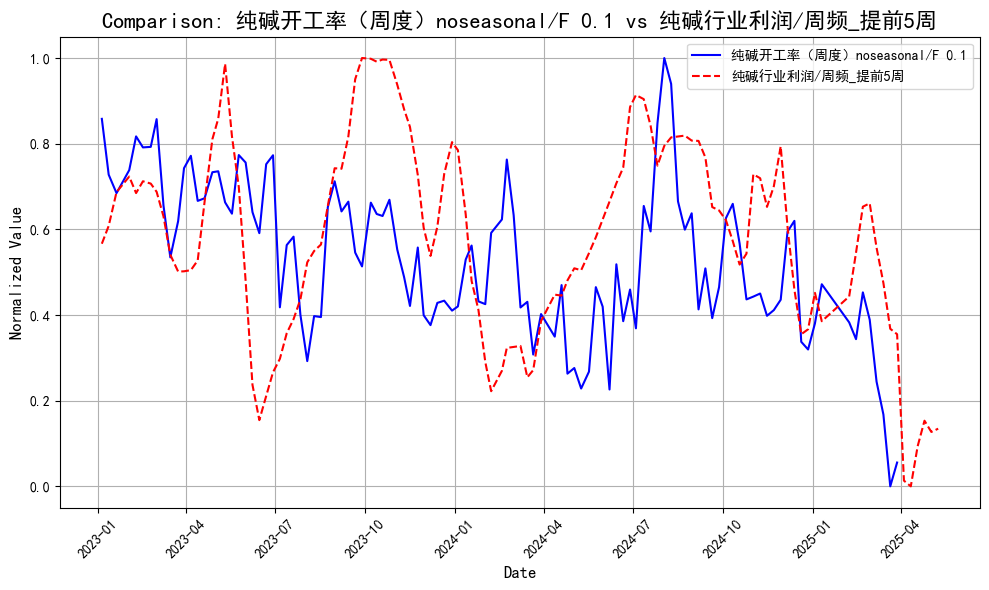

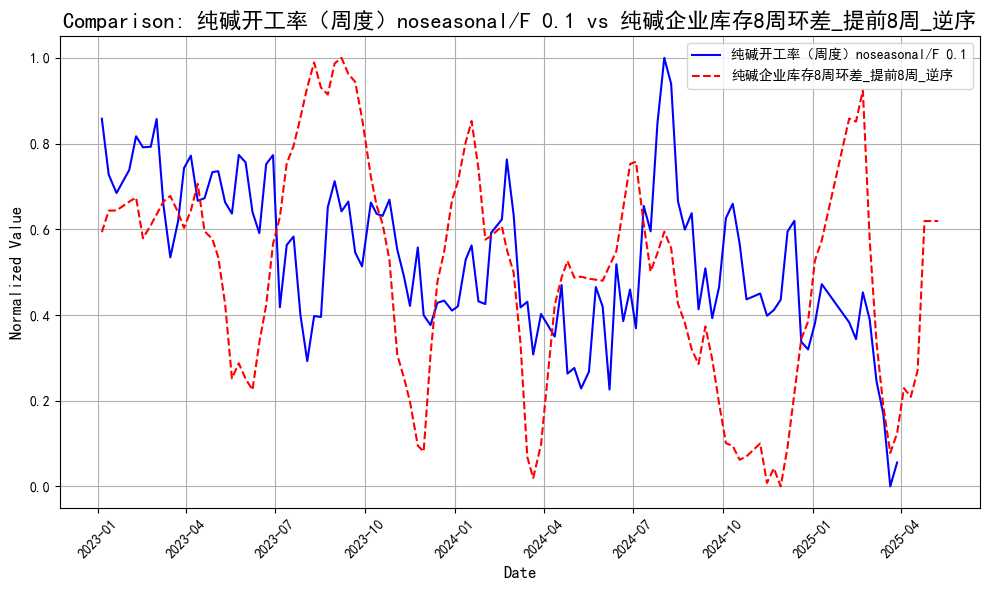

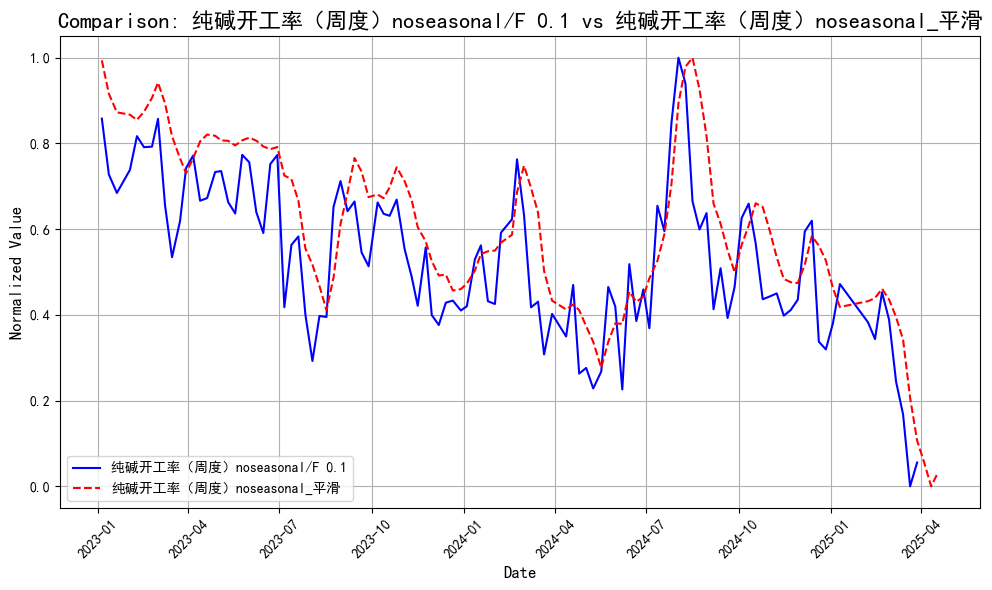

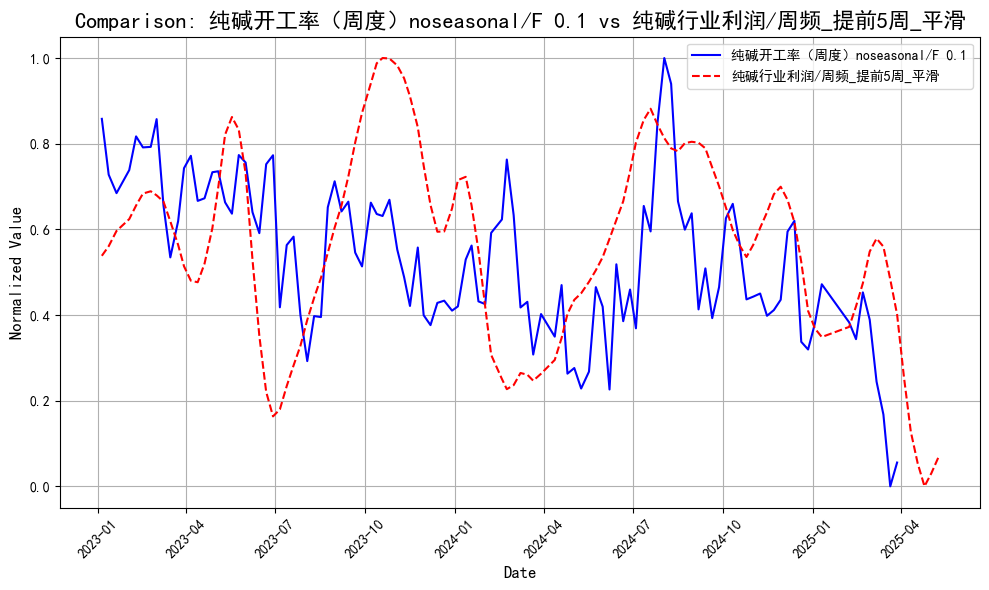

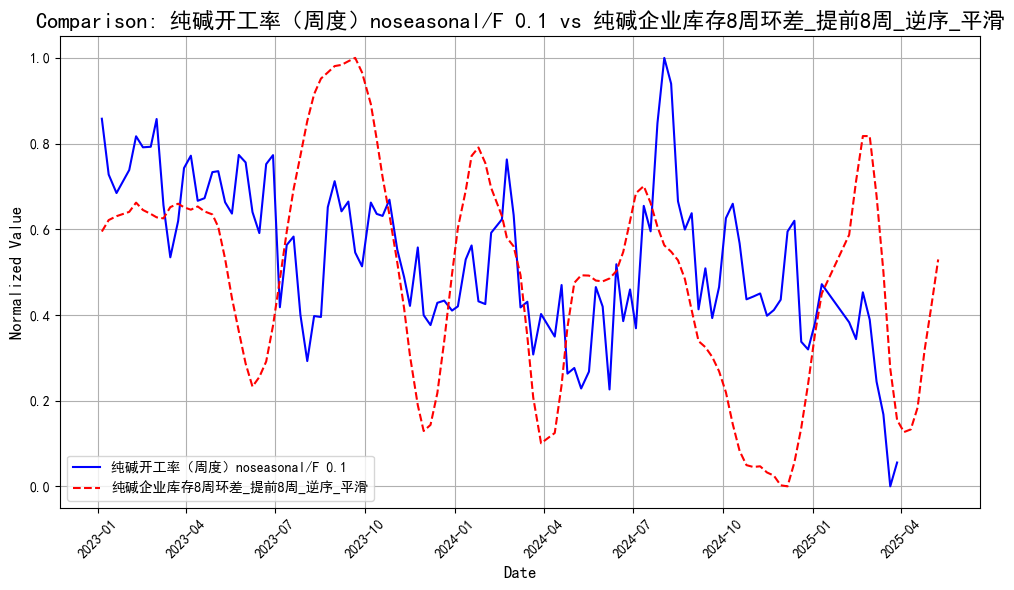

In [6]:
sheet_daily['纯碱开工率（周度）noseasonal_平滑'] = sheet_daily['纯碱开工率（周度）noseasonal/F 0.1'].rolling(window=4, min_periods=1).mean()
sheet_daily['纯碱行业利润/周频_提前5周_平滑'] = sheet_daily['纯碱行业利润/周频_提前5周'].rolling(window=4, min_periods=1).mean()
sheet_daily['纯碱企业库存8周环差_提前8周_逆序_平滑'] = sheet_daily['纯碱企业库存8周环差_提前8周_逆序'].rolling(window=4, min_periods=1).mean()
################################# X 和 Y 对比 观察领先性 #################################
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='纯碱开工率（周度）noseasonal/F 0.1', 
    compare_cols=[
        '纯碱行业利润/周频_提前5周',
        '纯碱企业库存8周环差_提前8周_逆序',
        '纯碱开工率（周度）noseasonal_平滑',
        '纯碱行业利润/周频_提前5周_平滑',
        '纯碱企业库存8周环差_提前8周_逆序_平滑'
       ]
)

In [7]:
# 准备训练和测试数据
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 20
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = ['纯碱行业利润/周频_提前5周_平滑','纯碱企业库存8周环差_提前8周_逆序_平滑']
predict_column = '纯碱开工率（周度）noseasonal_平滑'

# 训练模型
model = LinearRegression()
X_train = train_data[feature_columns].values
X_train = X_train.reshape(X_train.shape[0], len(feature_columns))
y_train = train_data[predict_column].values
model.fit(X_train, y_train)

# 在测试集上评估模型
X_test = test_data[feature_columns].values
X_test = X_test.reshape(X_test.shape[0], len(feature_columns))
y_test = test_data[predict_column].values
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# 计算评估指标
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print('模型评估指标:')
print(f'均方误差 (MSE): {mse:.6f}')
print(f'均方根误差 (RMSE): {rmse:.6f}')
print(f'平均绝对误差 (MAE): {mae:.6f}')
print(f'R2分数: {r2:.6f}')

# 对未来数据进行预测
X_future = future_data[feature_columns].values
X_future = X_future.reshape(X_future.shape[0], len(feature_columns))
future_predictions = model.predict(X_future)
future_data[f'{predict_column}_预测'] = future_predictions
train_data[f'{predict_column}_预测'] = y_pred_train
test_data[f'{predict_column}_预测'] = y_pred_test

模型评估指标:
均方误差 (MSE): 6.766038
均方根误差 (RMSE): 2.601161
平均绝对误差 (MAE): 2.112609
R2分数: -1.776578


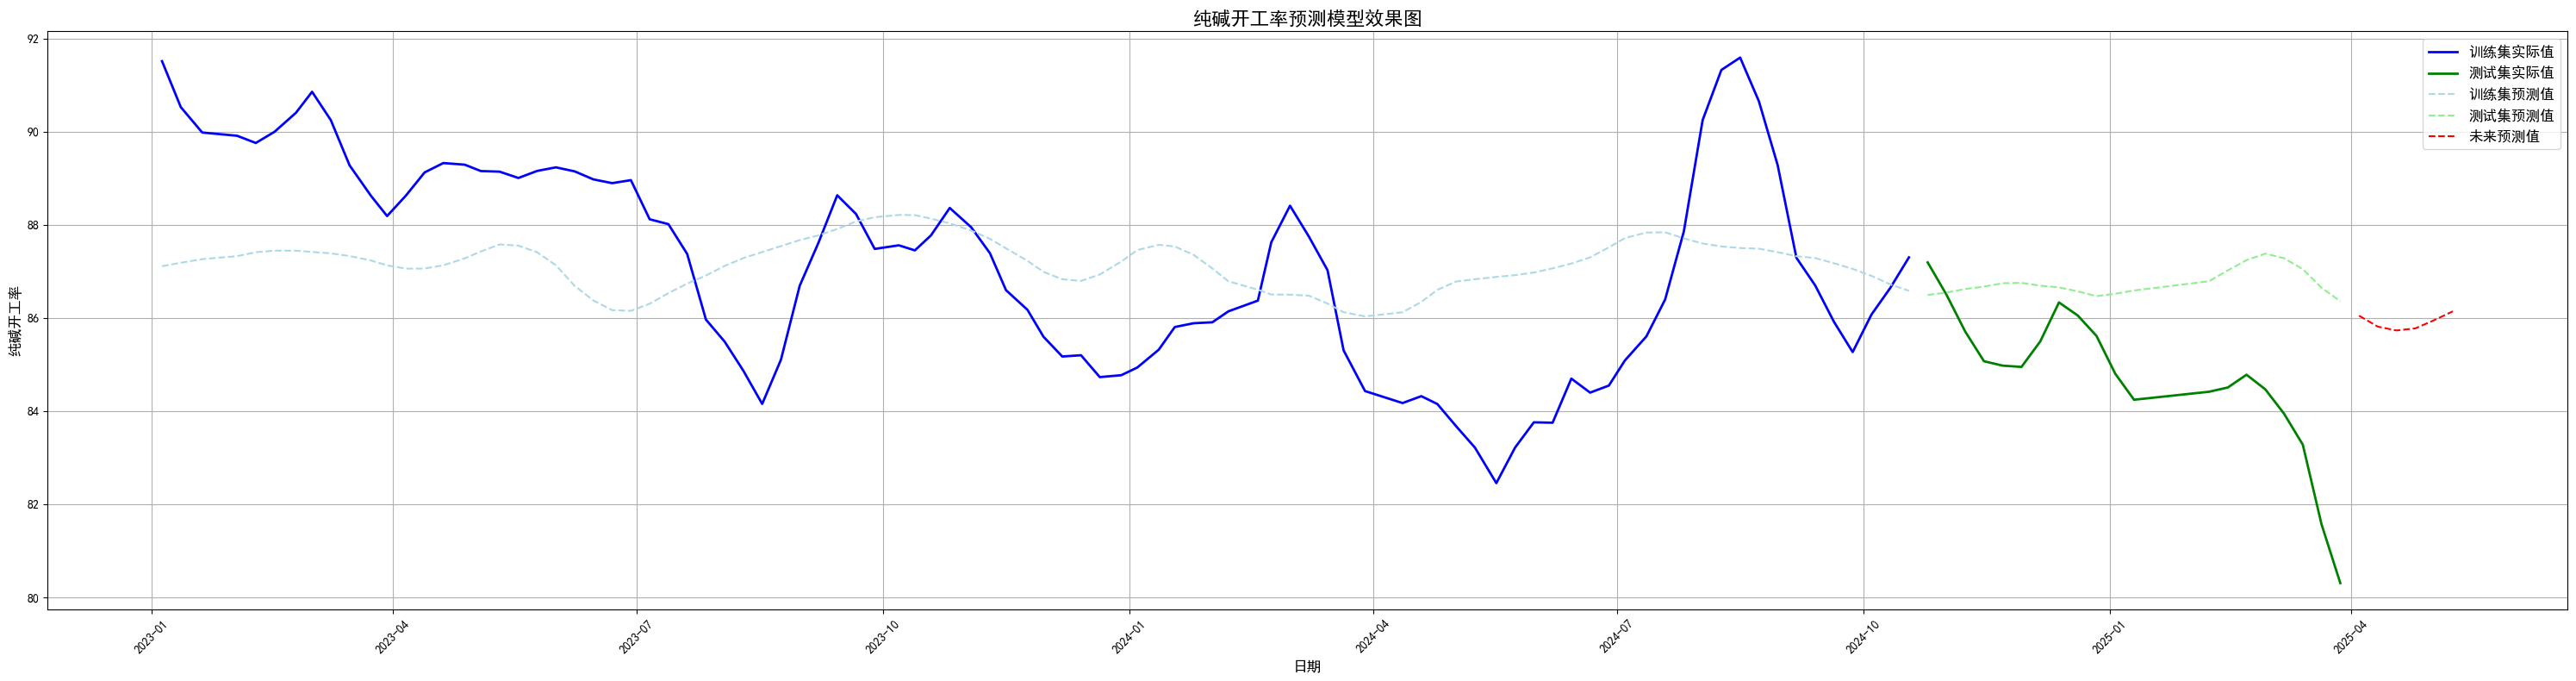

In [8]:
# 合并数据用于绘图
plot_data = pd.concat([train_data, test_data, future_data])

# 设置图形大小
plt.figure(figsize=(30, 8))

# 绘制历史数据
plt.plot(train_data['Date'], train_data[predict_column], 
         label='训练集实际值', color='blue', linewidth=2)
plt.plot(test_data['Date'], test_data[predict_column], 
         label='测试集实际值', color='green', linewidth=2)

# 绘制预测数据
plt.plot(train_data['Date'], train_data[f'{predict_column}_预测'], 
         label='训练集预测值', color='lightblue', linestyle='--')
plt.plot(test_data['Date'], test_data[f'{predict_column}_预测'], 
         label='测试集预测值', color='lightgreen', linestyle='--')
plt.plot(future_data['Date'], future_data[f'{predict_column}_预测'], 
         label='未来预测值', color='red', linestyle='--')

# 添加标题和标签
plt.title('纯碱开工率预测模型效果图', fontsize=16)
plt.xlabel('日期', fontsize=12)
plt.ylabel('纯碱开工率', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# 旋转x轴标签以防重叠
plt.xticks(rotation=45)

plt.tight_layout()
